<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/TU_Dortmund/blob/main/ASL_Sheet7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

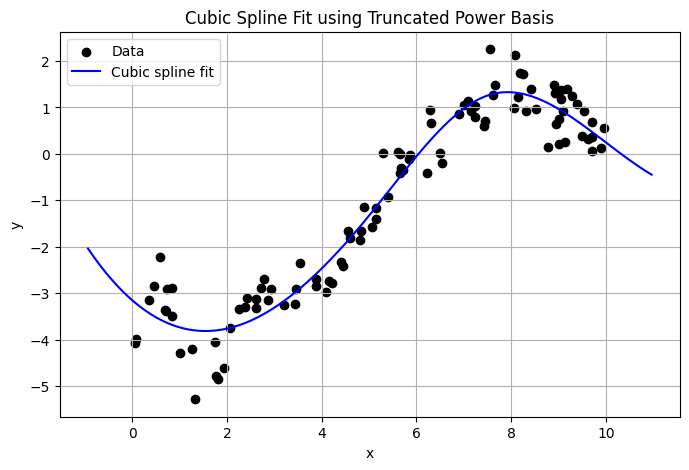

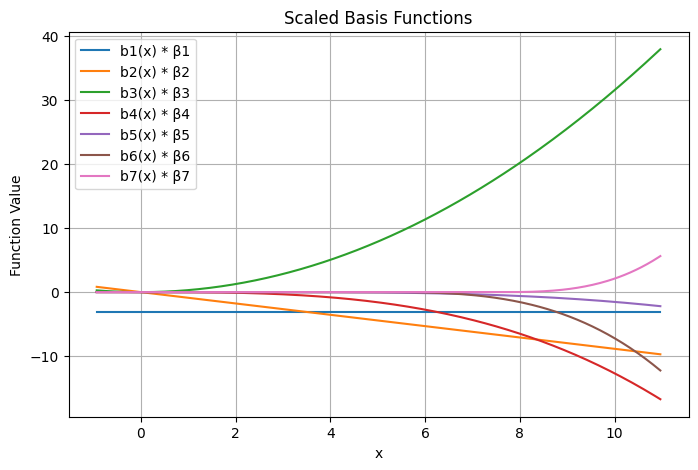

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
data = pd.read_csv('pw.csv')  # Upload pw.csv in Colab
x = data['x'].values
y = data['y'].values

# Step 2: Define truncated power basis function
def truncated_power_basis(x, knots):
    x = np.asarray(x)
    n = len(x)
    K = len(knots)
    X = np.zeros((n, 4 + K))
    X[:, 0] = 1
    X[:, 1] = x
    X[:, 2] = x**2
    X[:, 3] = x**3
    for i, knot in enumerate(knots):
        X[:, 4 + i] = np.where(x > knot, (x - knot)**3, 0)
    return X

# Step 3: Create design matrix
knots = [2.5, 5, 7.5]
X = truncated_power_basis(x, knots)

# Step 4: Estimate coefficients using least squares
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Step 5: Predict on grid
x_grid = np.linspace(min(x) - 1, max(x) + 1, 300)
X_grid = truncated_power_basis(x_grid, knots)
y_pred = X_grid @ beta_hat

# Step 6a: Plot data and fitted model
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='black', label='Data')
plt.plot(x_grid, y_pred, color='blue', label='Cubic spline fit')
plt.title('Cubic Spline Fit using Truncated Power Basis')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Step 6b: Plot scaled basis functions
scaled_basis = X_grid * beta_hat.reshape(1, -1)
plt.figure(figsize=(8, 5))
for i in range(scaled_basis.shape[1]):
    plt.plot(x_grid, scaled_basis[:, i], label=f'b{i+1}(x) * β{i+1}')
plt.title('Scaled Basis Functions')
plt.xlabel('x')
plt.ylabel('Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Step 3: Create and print design matrix (basis matrix)
X = truncated_power_basis(x, knots)

# Convert to DataFrame for easier viewing
import pandas as pd
X_df = pd.DataFrame(X, columns=[
    'b1(x) = 1',
    'b2(x) = x',
    'b3(x) = x^2',
    'b4(x) = x^3',
    'b5(x) = (x-2.5)^3_+',
    'b6(x) = (x-5)^3_+',
    'b7(x) = (x-7.5)^3_+'
])

# Print first 10 rows
print(X_df.head(10).round(3))

   b1(x) = 1  b2(x) = x  b3(x) = x^2  b4(x) = x^3  b5(x) = (x-2.5)^3_+  \
0        1.0      0.066        0.004        0.000                  0.0   
1        1.0      0.089        0.008        0.001                  0.0   
2        1.0      0.361        0.131        0.047                  0.0   
3        1.0      0.457        0.209        0.095                  0.0   
4        1.0      0.586        0.344        0.201                  0.0   
5        1.0      0.691        0.478        0.331                  0.0   
6        1.0      0.712        0.507        0.361                  0.0   
7        1.0      0.731        0.535        0.391                  0.0   
8        1.0      0.841        0.707        0.595                  0.0   
9        1.0      0.843        0.711        0.599                  0.0   

   b6(x) = (x-5)^3_+  b7(x) = (x-7.5)^3_+  
0                0.0                  0.0  
1                0.0                  0.0  
2                0.0                  0.0  
3        

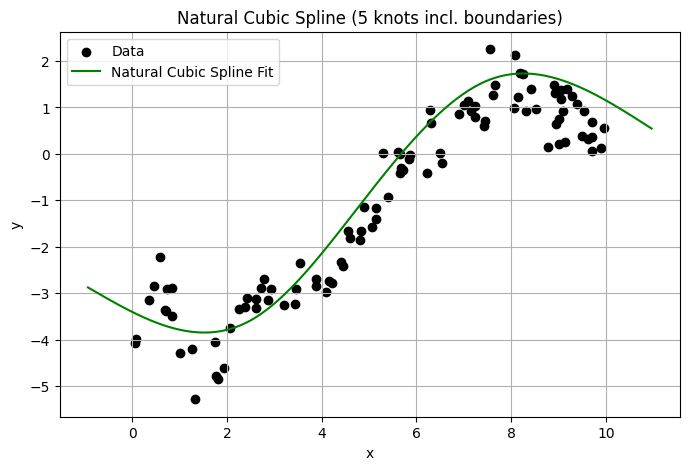

In [4]:
import statsmodels.api as sm
from patsy import dmatrix

# Step 1: Create natural cubic spline basis with 5 knots (including boundaries)
knots_b = [0, 2.5, 5, 7.5, 10]
spline_basis_b = dmatrix(
    "cr(x, knots=knots_b[1:-1], constraints='center')",
    {"x": x}, return_type='dataframe'
)

# Step 2: Fit the model
model_b = sm.OLS(y, spline_basis_b).fit()

# Step 3: Predict on grid
x_grid = np.linspace(min(x) - 1, max(x) + 1, 300)
spline_basis_grid_b = dmatrix(
    "cr(x_grid, knots=knots_b[1:-1], constraints='center')",
    {"x_grid": x_grid}, return_type='dataframe'
)
y_pred_b = model_b.predict(spline_basis_grid_b)

# Step 4: Plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='black', label='Data')
plt.plot(x_grid, y_pred_b, color='green', label='Natural Cubic Spline Fit')
plt.title("Natural Cubic Spline (5 knots incl. boundaries)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

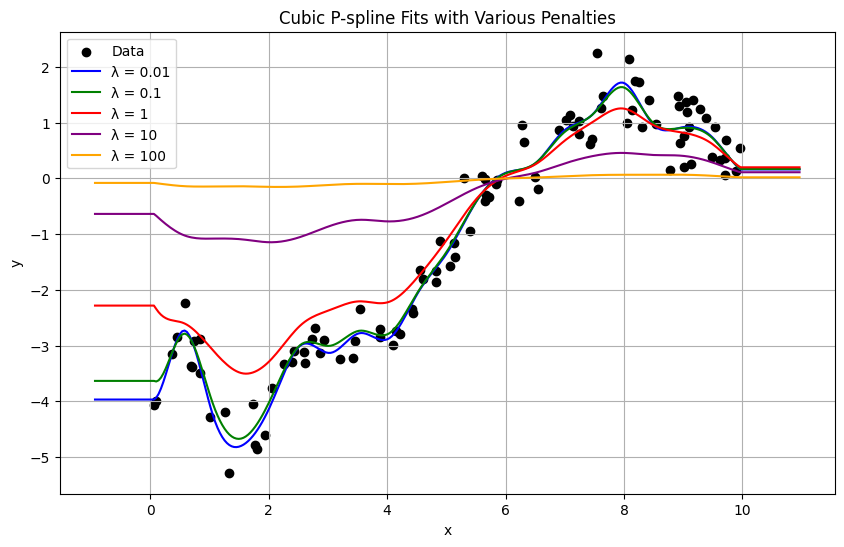

In [5]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer

# Step 1: Build B-spline basis manually
spline_transformer = SplineTransformer(
    degree=3, n_knots=21, include_bias=False, knots='uniform'
)
X_pspline = spline_transformer.fit_transform(x.reshape(-1, 1))

# Step 2: Fit P-spline models with different lambdas
lambdas = [0.01, 0.1, 1, 10, 100]
colors = ['blue', 'green', 'red', 'purple', 'orange']
x_grid = np.linspace(min(x) - 1, max(x) + 1, 300)
X_grid_pspline = spline_transformer.transform(x_grid.reshape(-1, 1))

plt.figure(figsize=(10,6))
plt.scatter(x, y, color='black', label='Data')

for lam, color in zip(lambdas, colors):
    model_pspline = Ridge(alpha=lam, fit_intercept=False)
    model_pspline.fit(X_pspline, y)
    y_pred_pspline = model_pspline.predict(X_grid_pspline)
    plt.plot(x_grid, y_pred_pspline, label=f'λ = {lam}', color=color)

plt.title("Cubic P-spline Fits with Various Penalties")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()